# Given a date, make a correspondance between 1 ARGO profile and NATL60 outputs : Laura's method

In [1]:
## magics

%load_ext version_information 
%version_information numpy,xarray,netCDF4

ImportError: No module named version_information

In [2]:
## path for mdules

import sys
sys.path.insert(0,"/home/albert/lib/python")

In [3]:
## imports

import numpy as np
import dask
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd 
import datetime
import glob as glob
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
import time
from dask.diagnostics import ProgressBar

%matplotlib inline

In [5]:
## datasets

#NATL60

dir="/media/extra/DATA/NATL60/NATL60-CJM165-S/"
file="NATL60-CJM165_y2012m06d14.1d_gridT.nc"

tfile=dir+file

!ls $tfile


/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2012m06d14.1d_gridT.nc


In [4]:
#ARGO
dir_ar="/home/users/albert6a/Data/ARGO/"
file062012="EN.4.2.0.f.profiles.g10.201206.nc"
files_ar="EN.4.2.0.f.profiles.g10.2012*.nc"

tfile062012=dir_ar+file062012
tfiles_ar=sorted(glob.glob(dir_ar+files_ar))

!ls $tfile062012


/home/users/albert6a/Data/ARGO/EN.4.2.0.f.profiles.g10.201206.nc


## Select ARGO profiles sampled at 14/06/2012 and within NATL60 boundaries

In [5]:
ii = 5 # looking at month 6, June:

# Load EN4 data (choose myfilesE12 or 13):
myfileE = tfiles_ar[ii]
print myfileE
dsE = xr.open_dataset(myfileE, lock=False)
latE = dsE.LATITUDE
lonE = dsE.LONGITUDE
depE = dsE.DEPH_CORRECTED
ptempE = dsE.POTM_CORRECTED
psalE = dsE.PSAL_CORRECTED
tE = dsE.JULD
w_inst_type = dsE.WMO_INST_TYPE
    
# Select box region:
lomin=-87
lomax=17
lamin=27
lamax=67

lonEbox = lonE.sel(N_PROF=(lonE>lomin)&(lonE<lomax)&(latE>lamin)&(latE<lamax), drop=True)    
latEbox = latE.sel(N_PROF=(lonE>lomin)&(lonE<lomax)&(latE>lamin)&(latE<lamax), drop=True)    
tempEbox = ptempE.sel(N_PROF=(lonE>lomin)&(lonE<lomax)&(latE>lamin)&(latE<lamax), drop=True)    
salEbox = psalE.sel(N_PROF=(lonE>lomin)&(lonE<lomax)&(latE>lamin)&(latE<lamax), drop=True)    
depEbox = depE.sel(N_PROF=(lonE>lomin)&(lonE<lomax)&(latE>lamin)&(latE<lamax), drop=True)    
tEbox = tE.sel(N_PROF=(lonE>lomin)&(lonE<lomax)&(latE>lamin)&(latE<lamax), drop=True)
w_inst_type_box = w_inst_type.sel(N_PROF=(lonE>lomin)&(lonE<lomax)&(latE>lamin)&(latE<lamax), drop=True)    

tEbox = tEbox.data

jj = 0 # selecting first profile available in June:

observation_lon = lonEbox[jj]
observation_lat = latEbox[jj]


/home/users/albert6a/Data/ARGO/EN.4.2.0.f.profiles.g10.201206.nc


In [6]:
def find_date(date,year,month,tday):
    prof=[]
    for t in np.arange(0,len(date)):
        ts = pd.to_datetime(str(date[t])) 
        dyear=ts.strftime('%Y')
        dmonth=ts.strftime('%m')
        dday=ts.strftime('%d')
        if dyear == year:
            if dmonth == month:
                if dday == tday:
                    prof.append(t)
        aprof=np.array(prof)
    return aprof
                    

In [7]:
t14=find_date(tEbox,'2012','06','14')
len(t14)

209

In [8]:
observation_lon = lonEbox[t14]
observation_lat = latEbox[t14]
observation_temp =  tempEbox[t14]   
observation_sal =  salEbox[t14]   
observation_dep =   depEbox[t14]  
observation_t = tEbox[t14]


## Plot one of the profile

In [9]:
def plot_profiles(nprof):
    gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[2,2])

    fig1 = plt.figure(figsize=(14, 16))  # (w,h)
    ax0 = plt.subplot(gs[0, :])
    ax1 = plt.subplot(gs[1, 0])
    ax2 = plt.subplot(gs[1, 1])

    my_map1 = Basemap(projection='merc', lat_0=(lamin+lamax)/2, lon_0=(lomin+lomax)/2, 
    resolution = 'i', ax = ax0,
    llcrnrlon = lomin, llcrnrlat= lamin,
    urcrnrlon = lomax, urcrnrlat = lamax, area_thresh = 10)

    my_map1.drawcoastlines() 
    my_map1.drawmapboundary()
    my_map1.drawmeridians(np.arange(-160, 140, 20), labels=[1,0,0,1], size=18)
    my_map1.drawparallels(np.arange(0, 70, 20), labels=[1,0,0,1], size=18)
    my_map1.scatter(observation_lon[nprof], observation_lat[nprof], latlon=True, c='g', linewidth='0', s=50)

    ax1.plot(observation_temp[nprof],observation_dep[nprof],'b.-')
    ax1.set_xlabel('Potential temperature [$^\circ$C]', size=16)
    ax1.set_ylabel('Depth [m]', size=14)
    ax1.set_ylim(observation_dep[nprof].max().data + 10, 0)
    ax1.grid(True, which='both')
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top') 
    
    
    ax2.plot(observation_sal[nprof],observation_dep[nprof],'b.-')
    ax2.set_xlabel('Practical salinity [psu]', size=16)
    ax2.set_ylabel('Depth [m]', size=14)
    ax2.set_ylim(observation_dep[nprof].max().data + 10, 0)
    ax2.grid(True, which='both')
    ax2.xaxis.tick_top()
    ax2.xaxis.set_label_position('top') 
    
    

/home/users/albert6a/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/users/albert6a/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/users/albert6a/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


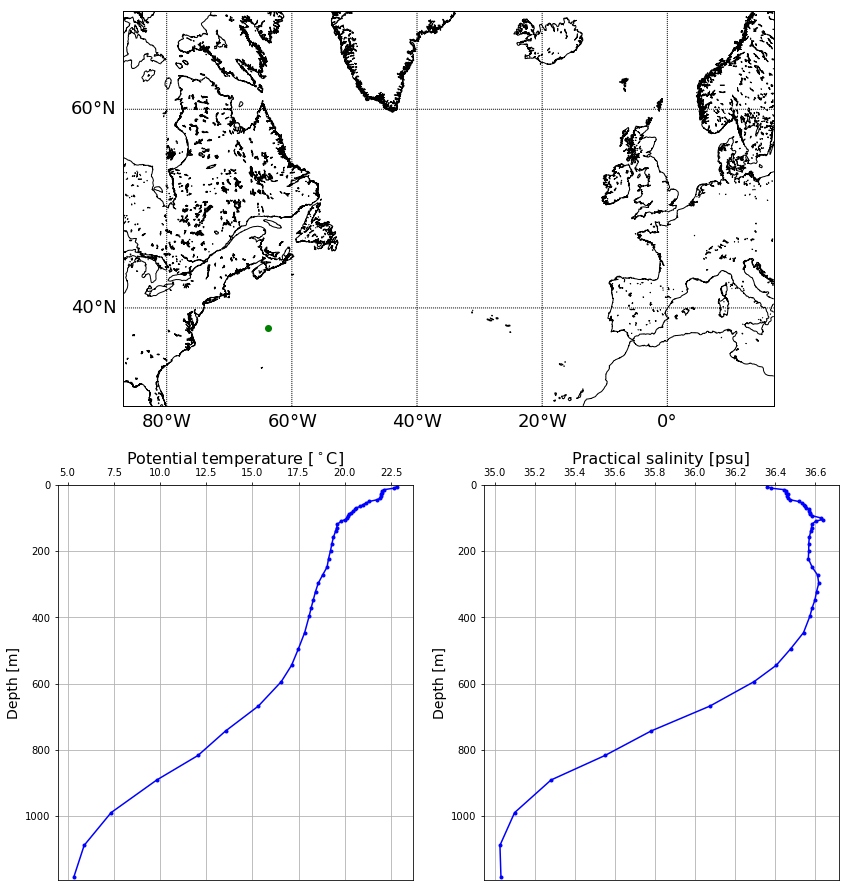

In [10]:
plot_profiles(0)

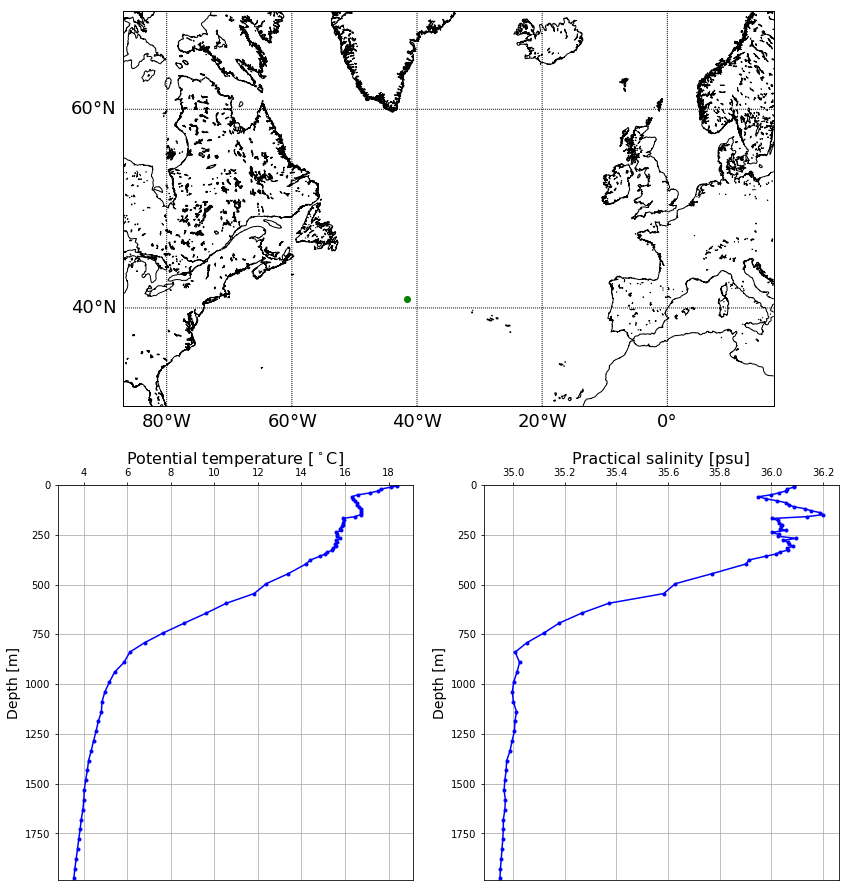

In [11]:
plot_profiles(10)

## Find the equivalent NATL60 region,  +/- 1° , at the surface

In [6]:
#dsN = xr.open_mfdataset(files_model, engine='h5netcdf', chunks={'deptht':30 ,'time_counter':1})
dsN = xr.open_dataset(tfile, chunks={'deptht':30 ,'time_counter':1})

In [7]:
latN = dsN.nav_lat
lonN = dsN.nav_lon
depN = dsN.deptht
model_temperature = dsN.votemper
model_salinity = dsN.vosaline
timN = dsN.time_counter

In [8]:
lomin = np.nanmin(lonN)
lomax = np.nanmax(lonN)
lamin = np.nanmin(latN)
lamax = np.nanmax(latN) 

In [9]:
print lomin 
print lomax 
print lamin 
print lamax 

-86.255
17.7867
26.5648
67.3871


In [10]:
model_temperature.shape 

(1, 300, 3454, 5422)

In [11]:
model_temperature_stacked = model_temperature.stack(profile=('x', 'y'))
model_salinity_stacked = model_salinity.stack(profile=('x', 'y'))
lonN_stacked = lonN.stack(profile=('x', 'y'))
latN_stacked = latN.stack(profile=('x', 'y'))

In [12]:
model_temperature_stacked.shape

(1, 300, 18727588)

In [ ]:
#ces opérations ne marchent qu'avec xarray 0.9.1

distance_threshold = 0.25
square_distance_to_observation = (lonN_stacked - 2.)**2 + (latN_stacked-38.)**2
is_close_to_observation = square_distance_to_observation < distance_threshold**2

model_temperature_near_observation = model_temperature_stacked.where(is_close_to_observation,drop=True)
model_salinity_near_observation = model_salinity_stacked.where(is_close_to_observation, drop=True)
lat_near_observation = latN_stacked.where(is_close_to_observation, drop=True)
lon_near_observation = lonN_stacked.where(is_close_to_observation, drop=True)

In [73]:
natl60=xr.open_dataset(tfile)
dep_nat=natl60['deptht']
lat_nat=natl60['nav_lat']
lon_nat=natl60['nav_lon']
temp_nat=natl60['votemper']
sal_nat=natl60['vosaline']
day_nat=natl60['time_counter']


In [74]:
len(dep_nat.values)

300

In [75]:
latval=lat_nat.values
lonval=lon_nat.values
tempval=temp_nat[0,0].values
salval=sal_nat[0,0].values

In [76]:
tempval.shape

(3454, 5422)

In [40]:
def select_region_temp(latr,lonr):
    templat=tempval[np.where(np.abs(latval-latr)<1)]
    lonlat=lonval[np.where(np.abs(latval-latr)<1)]
    tempr=templat[np.where(np.abs(lonlat-lonr)<1)]
    return tempr

In [77]:
temp37N63W=select_region_temp(37,-63)

In [78]:
print 'taille=',temp37N63W.shape
print 'mean=',np.mean(temp37N63W)
print 'min=',np.min(temp37N63W)
print 'max=',np.max(temp37N63W)

taille= (18672,)
mean= 23.3423507441
min= 19.0094432831
max= 25.6885318756


In [79]:
def select_region_sal(latr,lonr):
    sallat=salval[np.where(np.abs(latval-latr)<1)]
    lonlat=lonval[np.where(np.abs(latval-latr)<1)]
    salr=sallat[np.where(np.abs(lonlat-lonr)<1)]
    return salr

In [80]:
sal37N63W=select_region_sal(37,-63)

In [81]:
print 'taille=',sal37N63W.shape
print 'mean=',np.mean(sal37N63W)
print 'min=',np.min(sal37N63W)
print 'max=',np.max(sal37N63W)

taille= (18672,)
mean= 36.4046774711
min= 34.9465904236
max= 36.5759429932


## Loop over depth

In [87]:
def select_profiles_temp(latr,lonr):
    latval=lat_nat.values
    lonval=lon_nat.values
    mean_prof_temp=np.zeros(len(dep_nat.values))
    min_prof_temp=np.zeros(len(dep_nat.values))
    max_prof_temp=np.zeros(len(dep_nat.values))
    for z in np.arange(len(dep_nat.values)):
        tempval=temp_nat[0,z].values
        templat=tempval[np.where(np.abs(latval-latr)<1)]
        lonlat=lonval[np.where(np.abs(latval-latr)<1)]
        tempz=templat[np.where(np.abs(lonlat-lonr)<1)]
        mean_prof_temp[z]=np.mean(tempz)
        min_prof_temp[z]=np.min(tempz)
        max_prof_temp[z]=np.max(tempz)
    return mean_prof_temp, min_prof_temp, max_prof_temp


In [88]:
mean_temp37N63W,min_temp37N63W,max_temp37N63W=select_profiles_temp(37,-63)

In [89]:
mean_temp37N63W.shape

(300,)

##Plot All

In [100]:
def plot_temp_profile_all(nprof,meant,mint,maxt,depmod):
    plt.plot(temp_ar[nprof,:],-1*dep_ar[nprof,:])
    plt.xlabel('Potential temperature')
    plt.ylabel('depth')
    plt.plot(meant,-1*depmod,'k-')
    plt.plot(mint,-1*depmod,'k.')
    plt.plot(maxt,-1*depmod,'k--')
    plt.legend(['ARGO','mean NATL60','min NATL60','max NATL60'])
    ts = pd.to_datetime(str(day_ar.values[nprof])) 
    d = ts.strftime('%Y.%m.%d')
    title="ARGO profile at lat "+str(np.trunc(lat_ar.values[nprof]))+"deg N and lon "+str(np.trunc(lon_ar.values[nprof]))+"deg E "+str(d)
    plt.title(title)

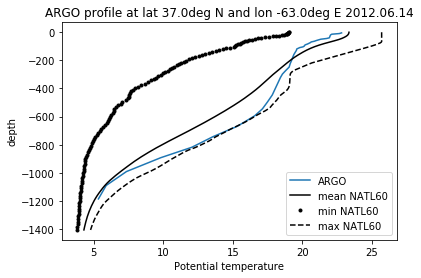

In [101]:
plot_temp_profile_all(t14natl[0],mean_temp37N63W,min_temp37N63W,max_temp37N63W,dep_nat)

In [98]:
def select_profiles_sal(latr,lonr):
    latval=lat_nat.values
    lonval=lon_nat.values
    mean_prof_sal=np.zeros(len(dep_nat.values))
    min_prof_sal=np.zeros(len(dep_nat.values))
    max_prof_sal=np.zeros(len(dep_nat.values))
    for z in np.arange(len(dep_nat.values)):
        salval=sal_nat[0,z].values
        sallat=salval[np.where(np.abs(latval-latr)<1)]
        lonlat=lonval[np.where(np.abs(latval-latr)<1)]
        salz=sallat[np.where(np.abs(lonlat-lonr)<1)]
        mean_prof_sal[z]=np.mean(salz)
        min_prof_sal[z]=np.min(salz)
        max_prof_sal[z]=np.max(salz)
    return mean_prof_sal, min_prof_sal, max_prof_sal
mean_sal37N63W,min_sal37N63W,max_sal37N63W=select_profiles_sal(37,-63)


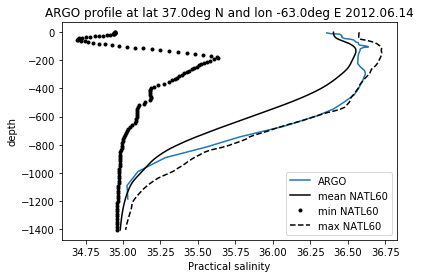

In [99]:
def plot_sal_profile_all(nprof,meant,mint,maxt,depmod):
    plt.plot(sal_ar[nprof,:],-1*dep_ar[nprof,:])
    plt.xlabel('Practical salinity')
    plt.ylabel('depth')
    plt.plot(meant,-1*depmod,'k-')
    plt.plot(mint,-1*depmod,'k.')
    plt.plot(maxt,-1*depmod,'k--')
    plt.legend(['ARGO','mean NATL60','min NATL60','max NATL60'])
    ts = pd.to_datetime(str(day_ar.values[nprof])) 
    d = ts.strftime('%Y.%m.%d')
    title="ARGO profile at lat "+str(np.trunc(lat_ar.values[nprof]))+"deg N and lon "+str(np.trunc(lon_ar.values[nprof]))+"deg E "+str(d)
    plt.title(title)
plot_sal_profile_all(t14natl[0],mean_sal37N63W,min_sal37N63W,max_sal37N63W,dep_nat)    